In [34]:
import torch     # PyTorch
import torch.nn as nn
import datasets  # Huggingface Datasets; actual data

from IPython.display import display  # image display
import matplotlib.pyplot as plt      # image display
from torchvision.utils import make_grid
%matplotlib inline                   

import random

from torchvision import transforms   # transformations
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm

In [2]:
dataset = datasets.load_dataset("DrishtiSharma/Anime-Face-Dataset")

Found cached dataset parquet (C:/Users/Timothy/.cache/huggingface/datasets/DrishtiSharma___parquet/DrishtiSharma--Anime-Face-Dataset-1886e0ceeb6ab6bb/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
dataset.shape

{'train': (63565, 1)}

In [4]:
def display_samples(dataset):
    
    # Choose a random sample of images from the dataset
    images = []
    for i in range(100):
        images.append( dataset[ random.randint(0, len(dataset) ) ]['image'] )
    
    # Create a 10x10 grid of subplots
    fig, axs = plt.subplots(10, 10, figsize=(64/5, 64/5))
    fig.subplots_adjust(hspace=0, wspace=0)

    # Display each image in a subplot without padding
    for i in range(10):
        for j in range(10):
            axs[i][j].imshow(images[i*10+j].resize((64,64)))
            axs[i][j].axis('off')

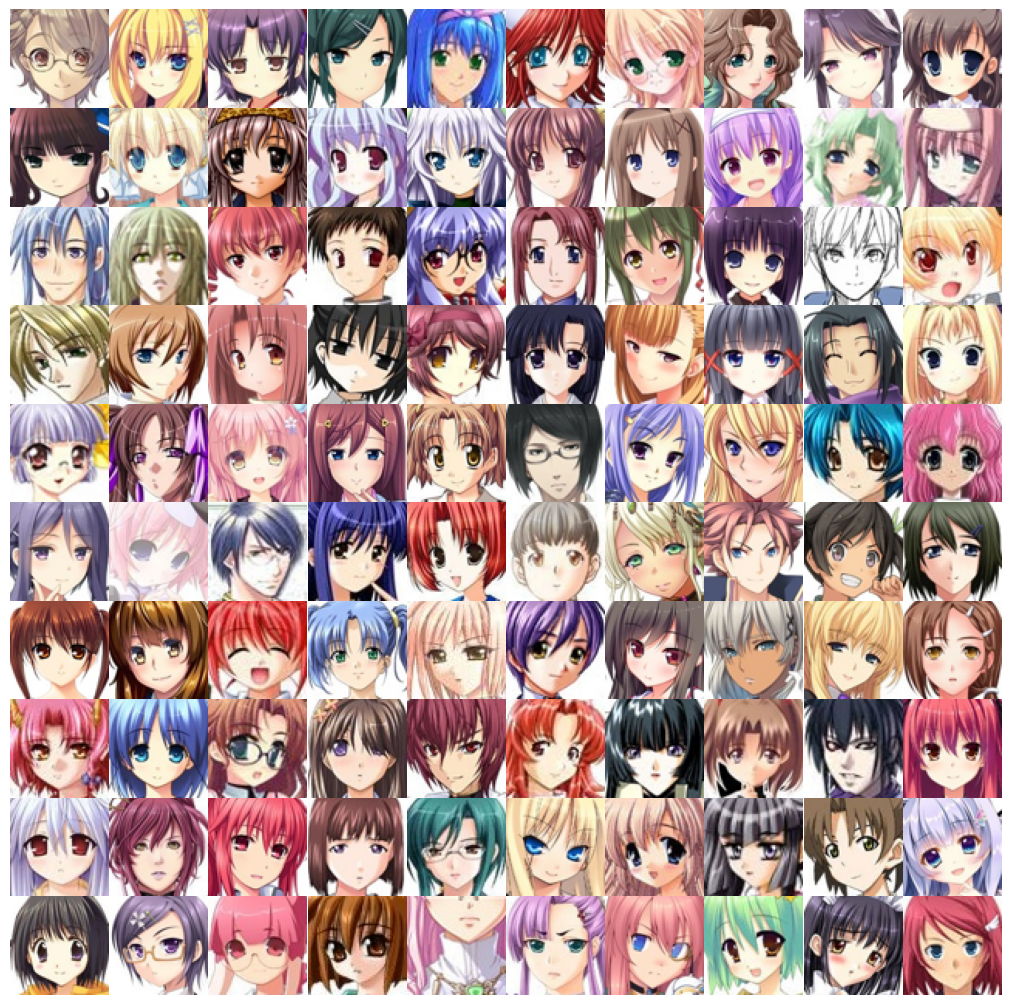

In [5]:
display_samples( dataset['train'] )

In [6]:
# Set the output size
output_size = (64, 64)

# Define a transform to resize the images
transform = transforms.Compose([
    transforms.Resize(output_size),
    transforms.ToTensor(),
])

# Create an empty list to store the resized images as tensors
resized_images = []

# Loop through each image in the dataset and resize it
for i in range( len(dataset['train']) ):
    image = dataset['train'][i]['image']  # Get the i-th image and its label
    image_resized = transform(image)  # Resize the image
    resized_images.append(image_resized)  # Add the resized image to the list
    
    if i % 1000 == 0:
        print("Making progress at ",i,"out of ",len(dataset['train']))

# Convert the list of tensors to a tensor stack
resized_images_tensor = torch.stack(resized_images)


Making progress at  0 out of  63565
Making progress at  1000 out of  63565
Making progress at  2000 out of  63565
Making progress at  3000 out of  63565
Making progress at  4000 out of  63565
Making progress at  5000 out of  63565
Making progress at  6000 out of  63565
Making progress at  7000 out of  63565
Making progress at  8000 out of  63565
Making progress at  9000 out of  63565
Making progress at  10000 out of  63565
Making progress at  11000 out of  63565
Making progress at  12000 out of  63565
Making progress at  13000 out of  63565
Making progress at  14000 out of  63565
Making progress at  15000 out of  63565
Making progress at  16000 out of  63565
Making progress at  17000 out of  63565
Making progress at  18000 out of  63565
Making progress at  19000 out of  63565
Making progress at  20000 out of  63565
Making progress at  21000 out of  63565
Making progress at  22000 out of  63565
Making progress at  23000 out of  63565
Making progress at  24000 out of  63565
Making progre

In [7]:
print(len(resized_images), resized_images_tensor.shape )

63565 torch.Size([63565, 3, 64, 64])


In [13]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

batch_size = 128
train_dl = DataLoader(resized_images_tensor, batch_size, shuffle=True, num_workers=2, pin_memory=True)
train_dl = DeviceDataLoader(train_dl, torch.device('cuda'))

In [16]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()
    
    )

In [20]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
discriminator = to_device(discriminator,  torch.device('cuda'))

In [21]:


latent_size = 128

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


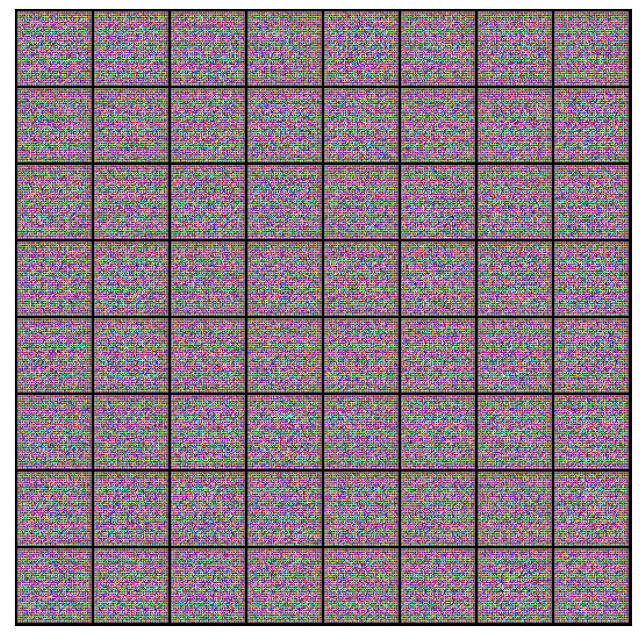

In [30]:


image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break



xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)



In [31]:
def fit(epochs, lr, start_idx=1, show=False):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
    return losses_g, losses_d, real_scores, fake_scores

In [32]:


lr = 0.0002
epochs = 30



In [35]:


history = fit(epochs, lr)



  0%|          | 0/497 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)